In [22]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
sample_submission = pd.read_csv("./_data/sample_submission.csv")
kospi_kosdaq = pd.read_csv("./_data/kosdaq_kospi1.csv", index_col=0)
stock_list = pd.read_csv("./_data/stock_list.csv")
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x: str(x).zfill(6)) #zfill 숫자만큼 자릿수 맞춰 0 채우기


In [3]:
kospi_kosdaq.head()

,KOSPI,KOSPI_VOLUME,KOSPI_P,KOSPI_FOREINGER,KOSPI_OVERTIME_VOLUME,KOSPI_OVERTIME_P,KOSPI_TOTAL,KOSDAQ,KOSDAQ_VOLUME,KOSDAQ_VOLUME_P,KOSDAQ_FOREINGER
Date,,,,,,,,,,,
2018. 01. 02,2479.65,23026,46007,2657,26221.0,47864.0,16135080,812.45,98920,66490,878
2018. 01. 03,2486.35,32734,59619,4006,33109.0,60196.0,16176340,822.31,120310,81576,600
2018. 01. 04,2466.46,32963,67930,3396,33384.0,68963.0,16049160,808.01,134645,83403,-35
2018. 01. 05,2497.52,30529,61571,2466,30877.0,63175.0,16249700,828.03,122915,77241,1855
2018. 01. 08,2513.28,30889,62723,3911,31143.0,64049.0,16347770,839.51,122898,85784,1401


In [4]:
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [5]:
stock_list

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI
...,...,...,...
365,맘스터치,220630,KOSDAQ
366,다날,064260,KOSDAQ
367,제이시스메디칼,287410,KOSDAQ
368,크리스에프앤씨,110790,KOSDAQ


In [6]:
stock_code = '005930' #삼성전자
predict_date = '20211129'  # 29일의 종가 예측
period = 365         # 1년간의 데이터를 사용

In [7]:
predict_date = pd.to_datetime(predict_date)
end_date = predict_date - datetime.timedelta(days=1) # 예측날짜의 하루전의 테이터까지만 사용
start_date = end_date - datetime.timedelta(days=period) # 1년 전의 데이터까지 사용

In [8]:
start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

In [9]:
start_weekday

5

In [10]:
max_weeknum

'47'

In [11]:
Business_days

,Date
0,2020-11-30
1,2020-12-01
2,2020-12-02
3,2020-12-03
4,2020-12-04
...,...
255,2021-11-22
256,2021-11-23
257,2021-11-24
258,2021-11-25


In [57]:
sample_code = stock_list.loc[0,'종목코드']
sample_code = '035720'
sample = fdr.DataReader(sample_code, start = start_date, end = end_date)[['Close']].reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
sample.Close = sample.Close.ffill()
sample = pd.pivot_table(data = sample, values = 'Close', columns = 'weekday', index = 'weeknum')
sample.head()

weekday,0,1,2,3,4
weeknum,,,,,
01,79483.0,78881.0,79383.0,80788.0,87111.0
02,90924.0,91827.0,91225.0,90623.0,87813.0
03,85806.0,88315.0,89118.0,91125.0,92931.0
04,95039.0,92530.0,93333.0,91928.0,88516.0
05,88616.0,89419.0,92731.0,91225.0,91326.0


In [58]:
model = LinearRegression()
x = sample.iloc[0:-2].to_numpy()
x.shape
y = sample.iloc[1:-1].to_numpy()
y_0 = y[:,0]
y_1 = y[:,1]
y_2 = y[:,2]
y_3 = y[:,3]
y_4 = y[:,4]

y_values = [y_0, y_1, y_2, y_3, y_4]
x_public = sample.iloc[-2].to_numpy()

In [59]:
predictions = []
for y_value in y_values :
    X_train, X_test, y_train, y_test = train_test_split(x, y_value, random_state=42, test_size=0.3)
    model.fit(X_train,y_train)
    score = model.score(X_test, y_test)
    prediction = model.predict(np.expand_dims(x_public,0))
    print(f"{prediction}")
    print(f"테스트 정확도:{score}")

    predictions.append(prediction[0])

[74142.22519646]
테스트 정확도:0.9192680987697153
[74397.03089835]
테스트 정확도:0.9227754108071604
[74660.99746144]
테스트 정확도:0.9118959115317076
[76262.22095404]
테스트 정확도:0.9414549683794465
[76195.17074567]
테스트 정확도:0.9415861516879717


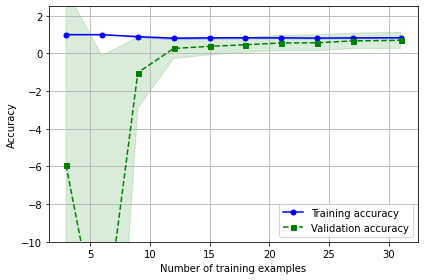

In [60]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=model, X=X_train,y=y_train, 
                                                        train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue',marker='o',
        markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean+train_std,
                train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--',
        marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std,
                test_mean -test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([-10, 2.5])
plt.tight_layout()
plt.show()

##### 

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
X_train, X_test, y_train, y_test = train_test_split(x, y_value, random_state=11, test_size=0.3)

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                           LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])